In [1]:
import os
import params
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy
from scipy.io import loadmat
from scipy.io import savemat
from PIL import Image
from IPython.display import display, clear_output
from scipy.optimize import curve_fit
import math
import skimage.filters
from skimage.transform import resize

In [2]:
def load_image_infos(file_name, key_name = "image_infos"):

    image_infos = scipy.io.loadmat(file_name)[key_name]

    XWorldLimits = image_infos[0][0][0][0]
    YWorldLimits = image_infos[0][0][1][0]
    ImageSize = image_infos[0][0][2][0]

    return XWorldLimits, YWorldLimits, ImageSize

def validate_ellipse(sta, ellipse_params, cell_nb, level_factor=0.4):
        
    fig, ax = plt.subplots(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')

    ax.set_title(f'Cell #{cell_nb}')
    gaussian = gaussian2D(sta.shape,*ellipse_params)
    ax.imshow(sta)
    ax.contour(np.abs(gaussian),levels = [level_factor*np.max(np.abs(gaussian))], colors='w',linestyles = 'solid', alpha = 0.8)
    plt.show()
    
    clear_output(wait=True)
    user_input = input()
    if user_input == '1':
        result = 1
    elif user_input == '0':
        result = -1
    else:
        print('Try again', end='\r')
        result = validate_ellipse(sta, ellipse_params, cell_nb)

    return result 

def find_angle(a,b,c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    return np.degrees(angle)

def find_aligned_point(point, ellipse, sanity_check=True):
    ellipse_center = np.mean(ellipse, axis=1)
    index = 0

    angle = 10000
    
    for i in range(360):
        angle_temp = find_angle(point,ellipse_center, ellipse[:,i])
        if angle_temp < angle:
            angle = angle_temp
            index = i
            
    closest_point = ellipse[:,index]
            
    if sanity_check:
            
        plt.figure()
        plt.plot(ellipse[1],ellipse[0])
        plt.scatter(ellipse_center[1],ellipse_center[0], marker='+')
        plt.scatter(closest_point[1],closest_point[0], color="green")
        plt.scatter(point[1],point[0], color='r')
        
            
    return closest_point

def get_ellipse(parameters,factor=1.5):
    amplitude, x0, y0, sigma_x, sigma_y, theta = parameters
    width = factor * 2.0 * sigma_x
    height = factor * 2.0 * sigma_y

    t = np.linspace(0, 2*np.pi, 360)
    
    Ell = np.array([sigma_x*np.cos(t) , sigma_y*np.sin(t)])
    
    R_rot = np.array([[np.cos(-np.deg2rad(theta)) , -np.sin(-np.deg2rad(theta))]
                      ,[np.sin(-np.deg2rad(theta)) , np.cos(-np.deg2rad(theta))]])  
    
    Ell = np.dot(R_rot, Ell)
    Ell[0,:] += x0
    Ell[1,:] += y0
    ell_size = np.abs(np.pi*width*height)
    ell_meas = 1-min(width, height)/max(width, height)
    
    return Ell, ell_size, ell_meas

def compute_distance_between_points(point_1, point_2):
    distance = np.linalg.norm(point_1 - point_2)
    return distance

## Cell 1: Load in STAs 

requires to have run the notebook nb 2, checkerboard analysis

In [3]:
################
#                /!\ CHANGE BELOW /!\
#                Name of 'sta_std_3D_fitted.pkl'
#                Number of checks
################


exp=params.exp
output_directory=params.output_directory
nb_xchecks=30
nb_ychecks=30

sta_results=np.load(os.path.join(output_directory,'sta_data_3D_fitted_30checks.pkl'),allow_pickle=True)
cells=list(sta_results.keys())

## and save them in Matlab format for registration (if not already done)

In [4]:
reg_directory='.\9_registration'
sta_mat_dir = os.path.normpath(os.path.join(reg_directory,r'sta_std'))        #  /!\ CHANGE HERE /!\
if not os.path.isdir(sta_mat_dir): os.makedirs(sta_mat_dir)

for cell_nb in tqdm(cells, desc="Saving STAs"):
    
    sta_2D=sta_results[cell_nb]['center_analyse']['Spatial']
    sta={}
    sta['sta'] = sta_2D
    savemat(os.path.join(sta_mat_dir,"sta_cell_{}.mat".format(cell_nb)), sta)

list_of_cells = {}
list_of_cells["list_of_cells"] = cells
scipy.io.savemat(os.path.join(reg_directory,"list_of_cells.mat"), list_of_cells)

Saving STAs:   0%|          | 0/189 [00:00<?, ?it/s]

# Run the Matlab registration code

describe here what happens in Matlab

## Cell 2: Load Matlab outputs

Requires to have done the registration procedure in Matlab

In [5]:
registration_directory = params.registration_directory

# Load the registered STAs
transformed_stas={}
for cell_nb in cells:
    transformed_stas[cell_nb] = loadmat(os.path.join(registration_directory, "sta_std\sta_cell_{}_transformed.mat".format(cell_nb)))["sta_mea"]
    
# Load the registered fluo image
fluo_image_registered = loadmat(os.path.join(registration_directory,"fluo_image_registered.mat"))["fluo_image_registered"]
    
# Dimension informations about the MEA frame of reference
XWorldLimits, YWorldLimits, ImageSize = load_image_infos(os.path.join(registration_directory,"sta_infos.mat"), key_name="sta_infos")
XWorldLimits_fluo, YWorldLimits_fluo, ImageSize_fluo = load_image_infos(os.path.join(registration_directory,"fluo_image_infos.mat"), key_name="fluo_image_infos")

#these are the coordinates of the holographic spots in the MEA frame of reference. Their frame of reference
#does not start from 0
dh_points_mea = loadmat(os.path.join(registration_directory,"dh_points_mea.mat"))['dh_points_mea']
nb_spots=dh_points_mea.shape[0]

#offset them so that they do start from zero like the reference frame in which the ellipse was fitted
offsetted_spots_coords = np.zeros(dh_points_mea.shape)
for i_spot in range(nb_spots):
    spot_coord = dh_points_mea[i_spot]
    offsetted_spots_coords[i_spot] = spot_coord-np.array([XWorldLimits[0], YWorldLimits[0]])

## Cell 3: Select the cells that have a good STA to try to fit an ellipse on them (if not already done)

Requires cell 1

In [6]:
print('Press 1 to validate the ellipse, 0 to discard it.')
good_stas=[]
for cell_nb in cells[:]:
    ell_10x=sta_results[cell_nb]['center_analyse']['EllipseCoor']
    result = validate_ellipse(sta_results[cell_nb]['center_analyse']['Spatial'], ell_10x, cell_nb)
    if result == 1:
        good_stas.append(cell_nb)
    else:
        continue

1


## save the list of selected cells so that you only have to do it once

In [7]:
np.save(os.path.join(output_directory,'Good_stas.npy'), good_stas)
print(len(good_stas))
np.array(good_stas)

135


array([  24,   28,   46,   85,  124,  150,  152,  188,  189,  190,  247,
        292,  294,  310,  325,  333,  342,  348,  389,  407,  411,  424,
        431,  445,  454,  457,  473,  476,  483,  496,  506,  507,  510,
        515,  516,  570,  581,  587,  591,  622,  625,  642,  674,  675,
        678,  681,  692,  699,  704,  716,  765,  769,  778,  788,  805,
        843,  850,  861,  864,  871,  872,  877,  880,  887,  896,  901,
        907,  910,  923,  924,  931,  935,  936,  940,  958,  977,  990,
        993,  995,  996, 1000, 1001, 1003, 1008, 1024, 1025, 1047, 1069,
       1096, 1104, 1135, 1137, 1152, 1157, 1175, 1183, 1205, 1251, 1269,
       1276, 1278, 1287, 1299, 1327, 1336, 1341, 1343, 1351, 1356, 1366,
       1370, 1406, 1437, 1469, 1473, 1481, 1497, 1520, 1533, 1534, 1543,
       1552, 1554, 1574, 1586, 1588, 1596, 1620, 1626, 1629, 1632, 1647,
       1649, 1650, 1656])

## Cell 4: Fit an ellipse for each cell with a good STA 

Requires either cell 3 or the file with the list of good STAs

An idea of what the fitting does: ....


  0%|          | 0/135 [00:00<?, ?it/s]

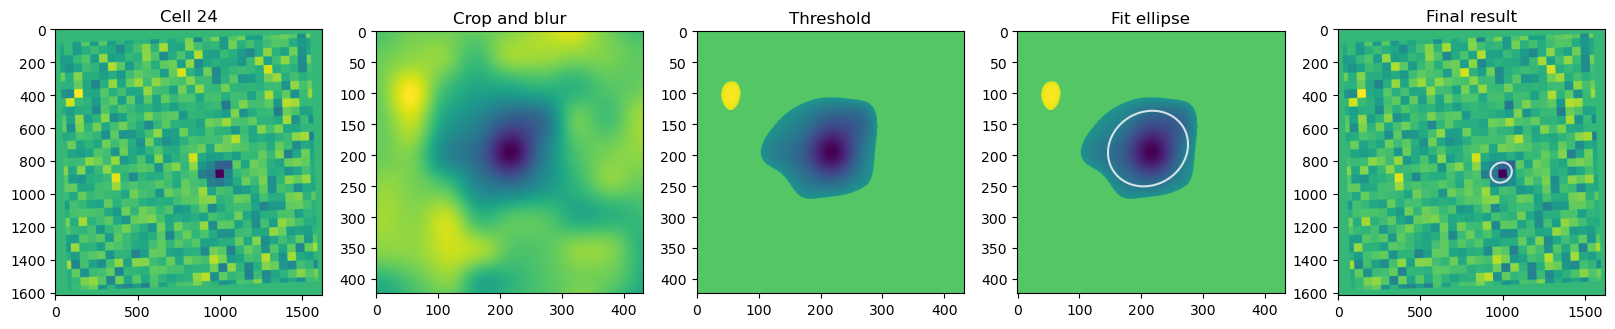

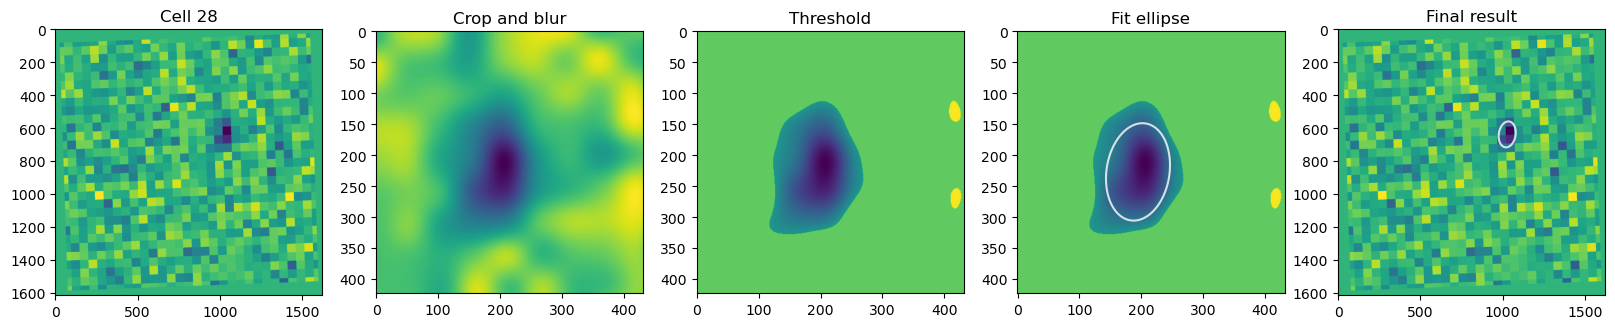

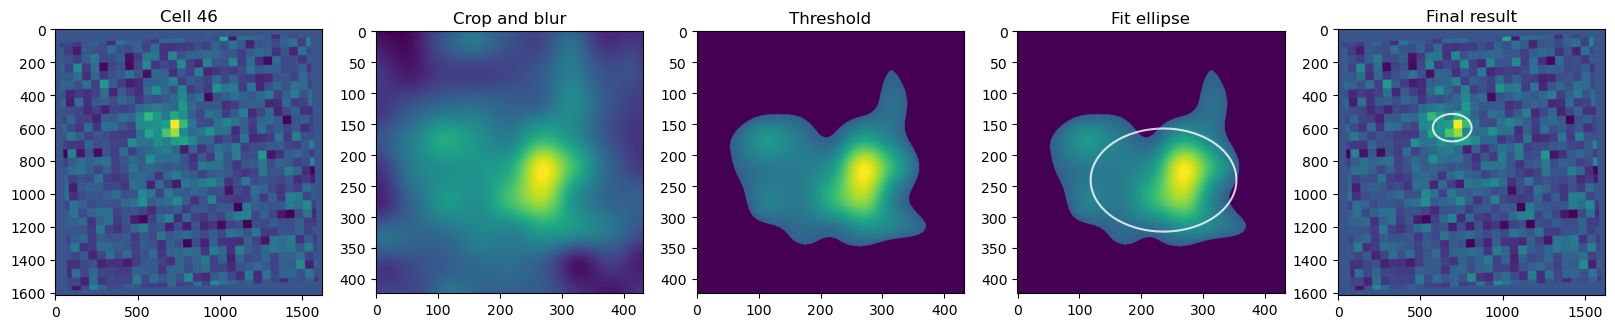

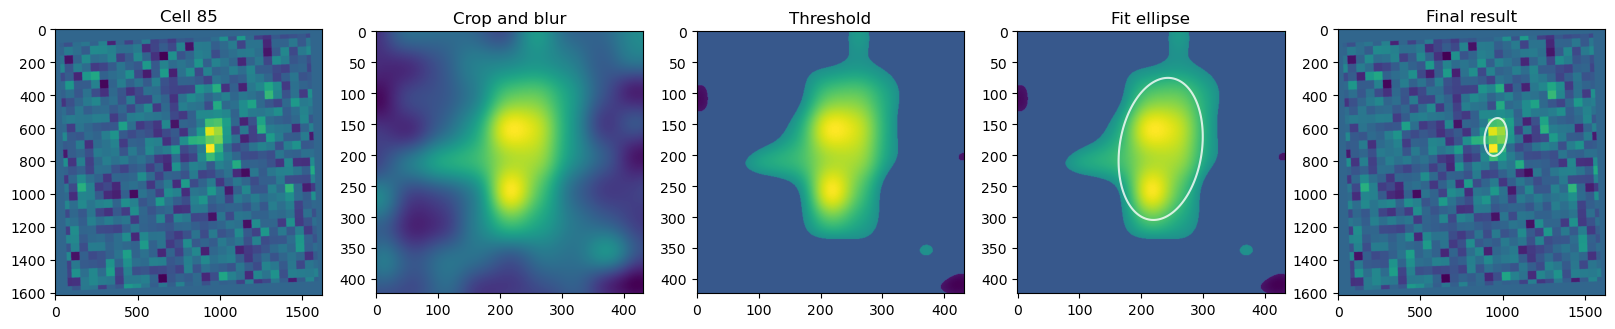

In [8]:
good_stas=np.load(os.path.join(output_directory,'Good_stas.npy'))

level_factor=0.4
sigma_blur = 20.0
treshold = 0.3

new_dim_x_pix=int(ImageSize[0]/nb_xchecks)
new_dim_y_pix=int(ImageSize[1]/nb_ychecks)
sigma_x_lim=new_dim_x_pix*4
sigma_y_lim=new_dim_y_pix*4

print('An idea of what the fitting does: ....')
registered_ellipses={}
for cell_nb in tqdm(good_stas[:]):
    
    #localize the interesting area of the transformed sta using the previously fit ellipse
    ell_10x=sta_results[cell_nb]['center_analyse']['EllipseCoor']
    gaussian = gaussian2D((nb_xchecks, nb_ychecks),*ell_10x)   #the 10x fit of a 2D gaussian
    gaussian_res = resize(gaussian, (ImageSize))   #resize the 2D gaussian to the MEA frame dimensions
    new_gauss=np.rot90(gaussian_res)[:,::-1]  #applying an approx transformation to make the resized gaussian resemble the position of the registered STA
    x_center=np.where(np.abs(new_gauss)==np.abs(new_gauss).max())[0][0]
    y_center=np.where(np.abs(new_gauss)==np.abs(new_gauss).max())[1][0]
    
    #bluring the transformed sta to avoid flat areas in the matrix to fit
    blurred_sta = skimage.filters.gaussian( transformed_stas[cell_nb], sigma=(sigma_blur, sigma_blur), truncate=3.5)
#     print(len(np.where(blurred==blurred.max())[0]))
    
    #cropping the blurred transformed sta around the interesting area
    cropped_tr_sta=blurred_sta[x_center- sigma_x_lim: x_center+sigma_x_lim, y_center-sigma_y_lim: y_center+ sigma_y_lim]
    
    try:
        #threshholding the cropped region to ease up the fit
        cropped_tr_sta /= np.abs(cropped_tr_sta).max()
        fitting_data = preprocess_fitting_matias(cropped_tr_sta, treshold=treshold)

        xdata = fitting_data.shape
        ydata = fitting_data.flatten()

        if abs(cropped_tr_sta.min())>cropped_tr_sta.max(): 
            ampl=-1
            ampl_ub=0
            ampl_lb=-2
        if cropped_tr_sta.max()>abs(cropped_tr_sta.min()): 
            ampl=1
            ampl_ub=2
            ampl_lb=0
        initial_guess = [ampl, sigma_y_lim, sigma_x_lim, new_dim_y_pix, new_dim_x_pix, 0]

        ellispe_params_bounds = ((ampl_lb, 0, 0, 0.1, 0.1, 0),(ampl_ub, fitting_data.shape[1], fitting_data.shape[0], sigma_x_lim, sigma_y_lim, 180))
        ellipse_params,cov = curve_fit(gaussian2D_flat, xdata, ydata, p0=initial_guess, bounds=ellispe_params_bounds)
        gaussian = gaussian2D(fitting_data.shape,*ellipse_params)
#     print(ellipse_params)

        transformed_y0=x_center+(ellipse_params[2]-sigma_x_lim)
        transformed_x0=y_center+(ellipse_params[1]-sigma_y_lim)
        transformed_ell_params= [ellipse_params[0],transformed_x0, transformed_y0] + list(ellipse_params[3:])
        transformed_gaussian = gaussian2D(transformed_stas[cell_nb].shape,*transformed_ell_params)
        
    except: transformed_ell_params= [0,0,0,0.01,0.01,0]
    
    if cell_nb<good_stas[4]:
        fig, ax=plt.subplots(nrows=1, ncols=5, figsize=(20,50))
        ax[0].imshow(transformed_stas[cell_nb])
        ax[0].set_title('Cell {}'.format(cell_nb))
        ax[1].imshow(cropped_tr_sta)
        ax[1].set_title('Crop and blur')
        ax[2].imshow(fitting_data)
        ax[2].set_title('Threshold')
        ax[3].imshow(fitting_data)
        ax[3].set_title('Fit ellipse')
        ax[4].imshow(transformed_stas[cell_nb])
        ax[4].set_title('Final result')
        if ellipse_params[0]!=0:
            ax[3].contour(np.abs(gaussian),levels = [level_factor*np.max(np.abs(gaussian))], colors='w',linestyles = 'solid', alpha = 0.8)
            ax[4].contour(np.abs(transformed_gaussian),levels = [level_factor*np.max(np.abs(transformed_gaussian))], colors='w',linestyles = 'solid', alpha = 0.8)
        plt.show()

    registered_ellipses[cell_nb] = transformed_ell_params

## Cell 5: Check that the ellipse fits were successful

All the cells with a good ellipse are saved in a list. Requires cell 4

In [9]:
good_stas=np.load(os.path.join(output_directory,'Good_stas.npy'))

cells_well_fitted=[]
for cell_nb in good_stas[:]:
    result = validate_ellipse(transformed_stas[cell_nb], registered_ellipses[cell_nb], cell_nb)
    if result == 1:
        cells_well_fitted.append(cell_nb)
    else:
        continue
        
print('Number of cells with a good ellipse: {}'.format(len(cells_well_fitted)))
print('List of cells with a good ellipse:\n {}'.format(np.array(cells_well_fitted)))

1
Number of cells with a good ellipse: 126
List of cells with a good ellipse:
 [  24   28   46   85  124  150  152  188  190  247  292  294  310  325
  333  342  348  389  407  411  431  445  454  457  473  476  483  496
  506  507  510  515  516  570  581  587  591  622  625  642  674  675
  678  681  692  699  704  716  778  788  805  843  850  861  864  871
  872  877  880  887  896  901  907  910  923  924  931  935  936  940
  958  977  990  993  995  996 1001 1003 1008 1024 1025 1047 1069 1096
 1104 1135 1137 1152 1157 1175 1183 1205 1269 1276 1278 1287 1327 1336
 1341 1343 1351 1356 1366 1370 1406 1437 1469 1473 1497 1533 1534 1543
 1552 1554 1574 1586 1588 1596 1620 1626 1629 1632 1647 1649 1650 1656]


## Save the parameters of the successful ones

In [10]:
good_registered_ellipses={}
for good_cell in cells_well_fitted:
    good_registered_ellipses[good_cell]=registered_ellipses[good_cell]
    
np.save(os.path.join(output_directory,'Well_fitted_registered_ellipses.npy'), good_registered_ellipses)

## Cell 6: Calculate the distance (in um) between the center of each cell's RF and each holographic spot

Requires either cell 5 or the file with the well fitted registered ellipses, plus cell 1 and 2

In [11]:
registered_ellipses = np.load(os.path.join(output_directory, 'Well_fitted_registered_ellipses.npy'), allow_pickle=True).item()
cells_well_fitted = list(registered_ellipses.keys())
nb_spots = dh_points_mea.shape[0]

Registration_distances={}
for cell_nb in tqdm(cells_well_fitted[:], desc="Computing distances with DH spots"):
    
    if not cell_nb in Registration_distances.keys(): Registration_distances[cell_nb]={}
    
    ell_params=registered_ellipses[cell_nb]
    RF_center = ell_params[1:3]
    ell,_,_= get_ellipse(ell_params, factor=2)
    
    for i_spot in range(nb_spots):
        #in these coordinates the axis don't start from zero
        spot_coord = offsetted_spots_coords[i_spot]
        
        #distance between the spot and the RF center
        distance = compute_distance_between_points(RF_center,spot_coord)
        
        closest_point = find_aligned_point(spot_coord, ell, sanity_check=False)
        radius = compute_distance_between_points(RF_center, closest_point)
        
        #ditance between spot and RF in terms of nb of RF width
        relative_distance = distance / radius
        
        Registration_distances[cell_nb][i_spot]={'absolute_distance': distance, 'relative_distance': relative_distance }

        
np.save(os.path.join(output_directory,'{}_RF_Holo_spots_distances.npy'.format(exp)), Registration_distances)        

Computing distances with DH spots:   0%|          | 0/126 [00:00<?, ?it/s]

-absolute distance:   the simple eucledean distance between the spot and the RF center

-relative distance :  a measure of whether and how much the holographic spot is inside the RF. For each spot                         the function 'find_aligned_point' finds the point of the RF ellipse that intersects the 
                      line that connects the spot and the RF center. This is called 'closest point' because                         it is the closest point of the RF contour to the holographic spot. The distance between                       this 'closest point' and the center of the ellipse is an angle specific RF radius and so
                      the relative distance is given as the absolute distance normalized by this radius

# Plotting. Absolute and relative distances

Requires cell 1 and 2 and either cell 6 or its saved output

In [12]:
fig_directory = os.path.normpath(os.path.join(output_directory,r'Registration_distances_plots'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

registered_ellipses = np.load(os.path.join(output_directory, 'Well_fitted_registered_ellipses.npy'), allow_pickle=True).item()
Distances= np.load(os.path.join(output_directory,'{}_RF_Holo_spots_distances.npy'.format(exp)), allow_pickle=True).item()

cells_well_fitted = list(registered_ellipses.keys())
for cell_nb in tqdm(cells_well_fitted[:]):
    
    fig = plt.figure(figsize=(30,20))
    gs = GridSpec(8, 12, left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=1.5, figure=fig) 
    
    #plot the trasformed sta with the ellipse and the holographic spots superimposed
    ax = fig.add_subplot(gs[0:8,0:8])
    sta=transformed_stas[cell_nb]
    if sta.max()>abs(sta.min()): 
        vmax=sta.max() 
        vmin=sta.min()
    if abs(sta.min())>sta.max(): 
        vmax=-sta.min() 
        vmin=sta.min()
        
    ax.imshow(sta, cmap='bwr', vmax=vmax,vmin=vmin)
    
    params=registered_ellipses[cell_nb]
    x,y=params[1:3]
    ellipse,_,_=get_ellipse(params, factor=2)
    
    ax.scatter(x,y, color='black')
    ax.scatter(ellipse[0], ellipse[1])
    
    for spot_nb in range(nb_spots):
        spot_coord = offsetted_spots_coords[spot_nb]
        ax.scatter(spot_coord[0], spot_coord[1], color='red', s=153)
        ax.annotate(spot_nb, (spot_coord[0],spot_coord[1]), (spot_coord[0]+15,spot_coord[1]+15), fontsize=28)
    ax.set_title('Transformed STA + Holographic spots superimposed', fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    
    #plot the ellipse and the holographic spots with their absolute distance
    ax = fig.add_subplot(gs[0:4,8:12])
    for spot_nb in range(nb_spots):
        spot_coord = offsetted_spots_coords[spot_nb]
        ax.scatter(spot_coord[0], spot_coord[1], s=153)#, color=colors[spot])
        ax.annotate(np.round(Distances[cell_nb][spot_nb]['absolute_distance'],0), (spot_coord[0],spot_coord[1]), (spot_coord[0]+15,spot_coord[1]+15), fontsize=18)

    ax.scatter(x,y, color='black')
    ax.scatter(ellipse[0], ellipse[1], lw=0.1)
    
    ax.set_xlim([x-300, x+300])
    ax.set_ylim([y-300, y+300])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_title('Absolute Distances (um)', fontsize=30)
    
    #plot the ellipse and the holographic spots with their relative distance
    ax = fig.add_subplot(gs[4:8,8:12])
    for spot_nb in range(nb_spots):
        spot_coord = offsetted_spots_coords[spot_nb]
        ax.scatter(spot_coord[0], spot_coord[1],s=153)#, color=colors[spot])
        ax.annotate(np.round(Distances[cell_nb][spot_nb]['relative_distance'],1), (spot_coord[0],spot_coord[1]), (spot_coord[0]+15,spot_coord[1]+15), fontsize=18)

    ax.scatter(x,y, color='black')
    ax.scatter(ellipse[0], ellipse[1], lw=0.1)
    
    ax.set_xlim([x-300, x+300])
    ax.set_ylim([y-300, y+300])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_title('Relative Distances', fontsize=30)

    fig.suptitle('Ganglion cell {}, all spots'.format(cell_nb), fontsize=35)
    fig_file = os.path.join(fig_directory,f'Cell_{cell_nb}.png')
    plt.savefig(fig_file, dpi=fig.dpi)
    plt.close()


  0%|          | 0/126 [00:00<?, ?it/s]

# ----------------------end of the notebook-------------------------

# Sanity checks. I keep them in case of future doubts given the complexity of the computations done in this notebook

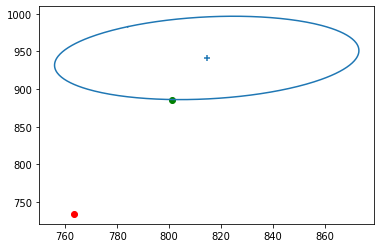

In [52]:
spot_coord = dh_points_mea[1]
offsetted_spots_coords = spot_coord-np.array([XWorldLimits[0], YWorldLimits[0]])
params=registered_ellipses[30]
ell,_,_= get_ellipse(params, factor=2)
closest_point = find_aligned_point(offsetted_spots_coords, ell, sanity_check=True)



[177.36095149  87.31129969]
[122.4826667  180.25068594]
[170.12113527 246.41912851]
[236.13581552 234.27677809]
[295.91131398 136.96322856]
[398.40163397 159.21185703]
[137.64988322 305.71858512]
[ 78.4842021  346.38852236]
[ 37.14892373 192.97848908]
778.6975450087972 652.881782059231


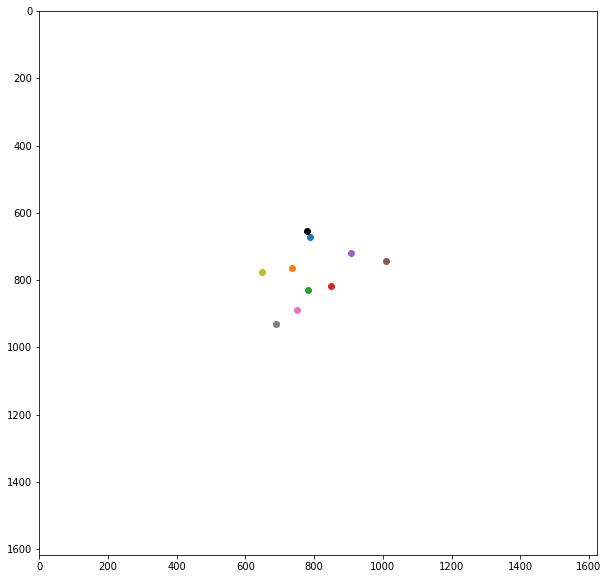

In [45]:
colors=['red','blue']

plt.figure(figsize=(10,10))
for spot in range(9):
    spot_coord=dh_points_mea[spot]
    print(spot_coord)
    plt.scatter(spot_coord[0]-XWorldLimits[0], spot_coord[1]-YWorldLimits[0])#, color=colors[spot])
for cell in cells_well_fitted[1:2]:
    x,y=registered_ellipses[cell][1:3]
    plt.scatter(x,y, color='black')
    print(x,y)
    plt.xlim([0, ImageSize[1]])
    plt.ylim([0, ImageSize[0]])
    plt.gca().invert_yaxis()

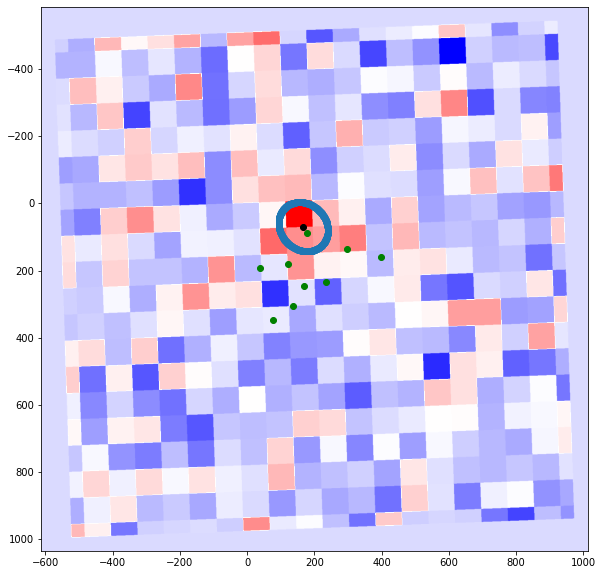

In [34]:
for cell_nb in cells_well_fitted[1:2]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sta=transformed_stas[cell_nb]
    if sta.max()>abs(sta.min()): 
        vmax=sta.max() 
        vmin=sta.min()
    if abs(sta.min())>sta.max(): 
        vmax=-sta.min() 
        vmin=sta.min()
    im = ax.imshow(sta, cmap='bwr', vmax=vmax,vmin=vmin, extent = (XWorldLimits[0], XWorldLimits[1], YWorldLimits[1], YWorldLimits[0]))
    ax.scatter(dh_points_mea[:,0], dh_points_mea[:,1], color='g')
    
    x,y=registered_ellipses[cell_nb][1:3]
    plt.scatter(x+XWorldLimits[0],y+YWorldLimits[0], color='black')
    params=registered_ellipses[cell_nb]
    
    ell=[params[0], params[1]+XWorldLimits[0], params[2]+YWorldLimits[0]] +list(params[3:])
    ellipse,_,_=get_ellipse(ell, factor=2)
    plt.scatter(ellipse[0], ellipse[1])

#     transformed_gaussian = gaussian2D(ImageSize,*ell)
#     plt.contour(np.abs(transformed_gaussian),levels = [level_factor*np.max(np.abs(transformed_gaussian))], colors='w',linestyles = 'solid', alpha = 0.8)

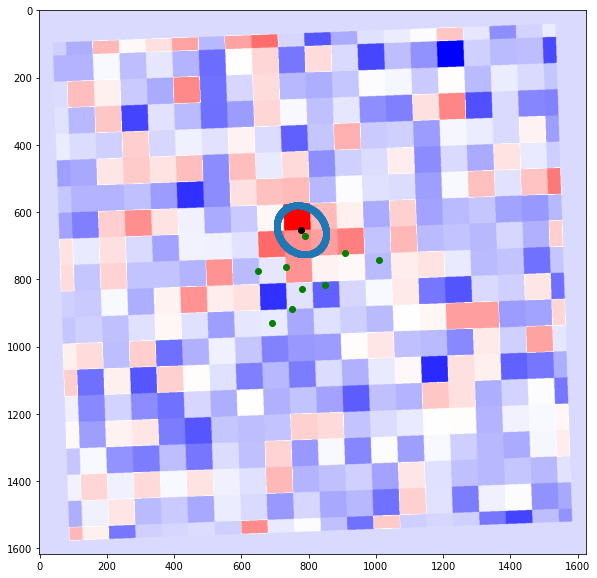

In [36]:
for cell_nb in cells_well_fitted[1:2]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sta=transformed_stas[cell_nb]
    if sta.max()>abs(sta.min()): 
        vmax=sta.max() 
        vmin=sta.min()
    if abs(sta.min())>sta.max(): 
        vmax=-sta.min() 
        vmin=sta.min()
    im = ax.imshow(sta, cmap='bwr', vmax=vmax,vmin=vmin)
    ax.scatter(dh_points_mea[:,0]-XWorldLimits[0], dh_points_mea[:,1]-YWorldLimits[0], color='g')
    
    x,y=registered_ellipses[cell_nb][1:3]
    plt.scatter(x,y, color='black')
    params=registered_ellipses[cell_nb]
    
    ellipse,_,_=get_ellipse(params, factor=2)
    plt.scatter(ellipse[0], ellipse[1])

## Understanding the transformation that Matlab does to the STAs

In [22]:
sta_10x=sta_results[30]['center_analyse']['Spatial']
sta_reg=transformed_stas[30]
print(sta_10x.shape, sta_reg.shape)
print(sta_10x.max(), sta_reg.max())
print(sta_10x.min(), sta_reg.min())

(20, 20) (1617, 1625)
0.3234081511823265 0.3234081511823265
-1.0 -1.0


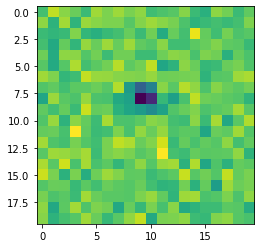

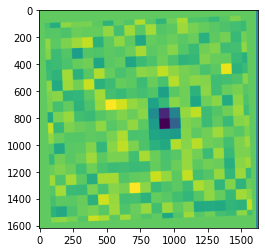

In [163]:
plt.figure()
plt.imshow(sta_10x)
plt.figure()
plt.imshow(sta_reg)
# plt.axhline(1617)
plt.axvline(1617)

(6132,)

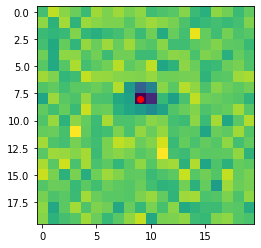

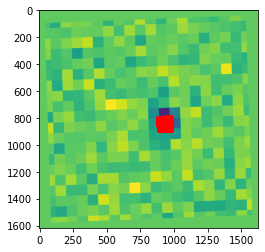

In [32]:
plt.figure()
plt.imshow(sta_10x)
plt.scatter(np.where(sta_10x==-1)[1], np.where(sta_10x==-1)[0], color='red')
plt.figure()
plt.imshow(sta_reg)
plt.scatter(np.where(sta_reg==-1)[1], np.where(sta_reg==-1)[0], color='red')
np.where(sta_reg==-1)[0].shape

the transformation does not change the values of the pixels, it just upsamples them and so the transformed sta has large areas with the same value

[-1.09418409e+00  1.03439940e+01  8.88866217e+00  8.91733058e-01
  7.68884970e-01  4.37239618e-50]
(array([10]), array([11]))


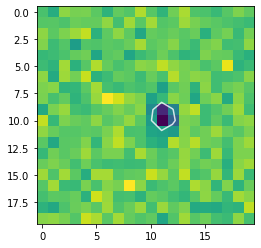

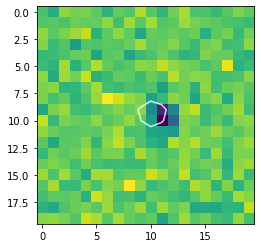

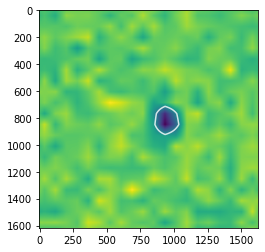

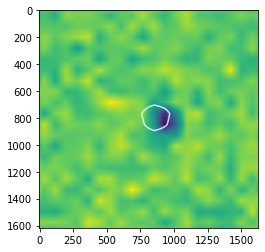

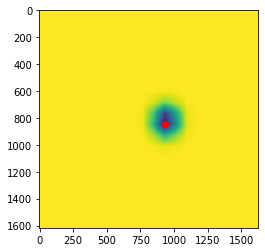

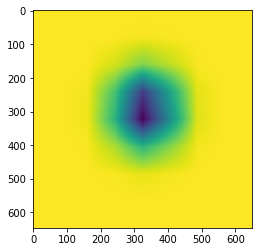

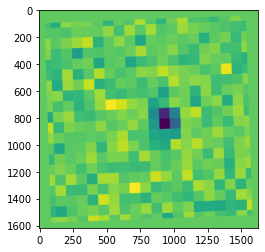

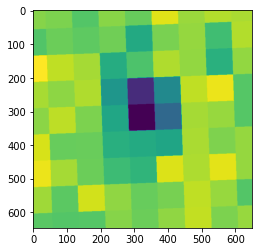

In [98]:
ell_10x=sta_results[30]['center_analyse']['EllipseCoor']
print(ell_10x)
level_factor=0.4

gaussian = gaussian2D(sta_10x.shape,*ell_10x)
plt.figure()
plt.imshow(np.rot90(sta_10x)[:,::-1])
new_gauss=np.rot90(gaussian)[:,::-1]
print(np.where(new_gauss==new_gauss.min()))
plt.contour(np.abs(new_gauss),levels = [level_factor*np.max(np.abs(new_gauss))], colors='w',linestyles = 'solid', alpha = 0.8)
plt.show()


plt.figure()
rot_ell=[ell_10x[0], ell_10x[2], ell_10x[1]] + list(ell_10x[3:])
new_ell=[rot_ell[0],  nb_ychecks-rot_ell[1], rot_ell[2]] + list(rot_ell[3:])
gaussian = gaussian2D(sta_10x.shape,*new_ell)
plt.imshow(np.rot90(sta_10x)[:,::-1])
plt.contour(np.abs(gaussian),levels = [level_factor*np.max(np.abs(gaussian))], colors='w',linestyles = 'solid', alpha = 0.8)
plt.show()

plt.figure()
rot_sta_resized = resize(np.rot90(sta_10x)[:,::-1], (sta_reg.shape))
plt.imshow(rot_sta_resized)
gaussian = gaussian2D(sta_10x.shape,*ell_10x)
new_gauss=np.rot90(gaussian)[:,::-1]
res_new_gauss=resize(new_gauss, (sta_reg.shape))
plt.contour(np.abs(res_new_gauss),levels = [level_factor*np.max(np.abs(res_new_gauss))], colors='w',linestyles = 'solid', alpha = 0.8)
plt.show()

plt.figure()
rot_ell=[ell_10x[0], ell_10x[2], ell_10x[1]] + list(ell_10x[3:])
new_ell=[rot_ell[0],  nb_ychecks-rot_ell[1], rot_ell[2]] + list(rot_ell[3:])
gaussian = gaussian2D(sta_10x.shape,*new_ell)
gaussian_res = resize(gaussian, (sta_reg.shape))
plt.imshow(rot_sta_resized)
plt.contour(np.abs(gaussian_res),levels = [level_factor*np.max(np.abs(gaussian_res))], colors='w',linestyles = 'solid', alpha = 0.8)
plt.show()

plt.figure()
plt.imshow(res_new_gauss)
plt.scatter(np.where(res_new_gauss==res_new_gauss.min())[1], np.where(res_new_gauss==res_new_gauss.min())[0], color='red')

plt.figure()
x_center=np.where(res_new_gauss==res_new_gauss.min())[0][0]
y_center=np.where(res_new_gauss==res_new_gauss.min())[1][0]
plt.imshow(res_new_gauss[x_center- sigma_x_lim: x_center+sigma_x_lim, y_center-sigma_y_lim: y_center+ sigma_y_lim])

plt.figure()
plt.imshow(sta_reg)
plt.figure()
plt.imshow(sta_reg[x_center- sigma_x_lim: x_center+sigma_x_lim, y_center-sigma_y_lim: y_center+ sigma_y_lim])
